## Семинар 10: "Генерация текстов"

ФИО: Жолковский Евгений Константинович

In [63]:
import numpy as np
import re
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import sys
import progressbar
%matplotlib inline

Этот семинар посвящен чат-ботам. Вам предстоит реализовать модель, генерирующую определенные тексты. В качестве текстов можно взять сборник цитат умных людей, предсказаний и т.д. На семинаре мы используем данные https://github.com/alvations/Quotables/blob/master/author-quote.txt

При реализации задания вы можете пользоваться кодом из этого примера: <a href=https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb>Generating Shakespeare with a Character-Level RNN</a>

### Часть 1: подготовка данных

Реализуйте датасет для дальнейшего обучения (будем использовать batch size=1)

In [64]:
! head -n 2 author-quote.txt

A. A. Milne	If you live to be a hundred, I want to live to be a hundred minus one day so I never have to live without you.
A. A. Milne	Promise me you'll always remember: You're braver than you believe, and stronger than you seem, and smarter than you think.


In [65]:
lines = [x.split('\t')[1].strip() for x in open('author-quote.txt').readlines()]

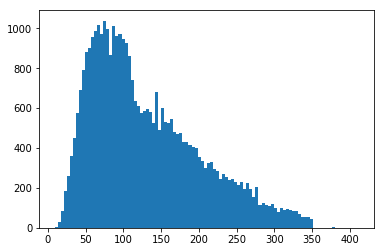

In [66]:
plt.hist(map(len, lines), bins=100);

In [67]:
lines = filter(lambda x: len(x) <= 50, lines)

In [68]:
class Vocabulary:
    def __init__(self, sentences):
        all_characters = set()
        for line in sentences:
            all_characters |= set(line)
        all_characters = list(all_characters)+['<eos>', '<go>']
        self.char_to_id = {x[1]:x[0] for x in enumerate(all_characters)}
        self.id_to_char = {x[0]:x[1] for x in enumerate(all_characters)}
        self.size = len(all_characters)

    def encode(self, line):
        return np.array([self.char_to_id[x] for x in line])
    
    def decode(self, tokens):
        return ''.join([self.id_to_char[x] for x in tokens])

In [69]:
vocab = Vocabulary(lines)

In [70]:
assert vocab.decode(vocab.encode(lines[0])) == lines[0]

In [71]:
class Quotes(Dataset):
    def __init__(self, sentences, vocab):
        # Construct vocabulary + EOS & GO tokens
        self.sentences = sentences
        self.vocab = vocab
        
    def __len__(self):
        return len(self.sentences)
        
    def __getitem__(self, idx):
        input = self.vocab.encode(['<go>'] + list(self.sentences[idx]))
        output = self.vocab.encode(list(self.sentences[idx])+['<eos>'])
        return input, output

In [72]:
dataset = Quotes(lines, vocab)

In [73]:
dataloader = DataLoader(dataset, shuffle=True)

### Часть 2: определение модели

In [74]:
class Oracle(nn.Module):
    def __init__(self, vocabulary_size, embedding_size=128, hidden_size=256, layers=2):
        super(Oracle, self).__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.generator = nn.GRU(embedding_size, hidden_size, layers, batch_first=True)
        self.classifier = nn.Linear(hidden_size, vocabulary_size)
    
    def forward(self, input):
        embedding = self.embedding(input)
        h = Variable(torch.zeros(self.layers, 1, self.hidden_size))
        output, _ = self.generator(embedding, (h))
        classes = self.classifier(output[0])
        return classes
    
    def generate(self, vocab, max_len=100):
        # TODO: replace with sampling
        h = Variable(torch.zeros(self.layers, 1, self.hidden_size))
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and len(line) < max_len:
            token = torch.Tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = Variable(token, volatile=True)
            embedding = self.embedding(token_id)
            output, (h) = self.generator(embedding, (h))
            classes = self.classifier(output[0])
            new_token_id = np.argmax(classes.data.numpy()) # <- here
            current_token = vocab.id_to_char[new_token_id]
            line = line + current_token
        return line

In [75]:
oracle = Oracle(vocab.size, embedding_size=32, hidden_size=64, layers=2)

### Часть 3: обучение модели

In [76]:
optimizer = torch.optim.Adam(oracle.parameters(), lr=0.01)

In [77]:
criterion = nn.CrossEntropyLoss()

In [78]:
losses = []

In [79]:
for epoch in range(1000):
    bar = progressbar.ProgressBar()
    
    for i, (batch, target) in enumerate(dataloader):
        batch = Variable(batch)
        target = Variable(target, requires_grad=False)[0]
        prediction = oracle(batch)
        loss = criterion(prediction, target)
        loss.backward()
        if i%32 == 0: # aka batch
            optimizer.step()
            oracle.zero_grad()
            losses.append(loss.data[0])
            print loss.data[0], oracle.generate(vocab)

4.31170034409 ff  iitit oiitt oiitt oiitt oiitt oiitt oiitt oiitt oiitt oiitt oiitt oiitt oiitt oiitt oiitt oiitt 
4.1964468956 l ooii ii ioi ii ioi ii ioi ii ioi ii ioi ii ioi ii ioi ii ioi ii ioi ii ioi ii ioi ii ioi ii ioi ii
3.90279102325 l ooooooi ooooooo oooooooi ooooooo oooooooi ooooooo oooooooi ooooooo oooooooi ooooooo oooooooi ooooo
3.5602016449  ooo oo oo oo oo oo oo oo oo oo oo oo oo oo oo oo oo oo oo oo oo oo oo oo oo oo oo oo oo oo oo oo oo
3.15651035309                                                                                                     
3.09383511543                                                                                                     
2.89671158791                                                                                                     
3.02998614311                                                                                                     
3.11980772018  i                                                                  

2.18466854095 I an a the the the the the the the the the the the the the the the the the the the the the the the t
2.2633061409 I all the a the the the the the the the the the the the the the the the the the the the the the.<eos>
1.77077233791 I a the a the a the the the the the the the the the the the the the the the the the the the the the 
2.3250451088 I an a the a the a the the the the the the the the the the the the the the the the the the the the t
2.62959885597 I an a the the the the the the the the the the the the the the the the the the the the the the the t
2.14681506157 I an a the the the the the the the the the the the the the the the the the the the the the the the t
2.07274651527 I an a the the the the the the the the the the the the the the the the the the the the the the the t
1.72176802158 I wan the the the the the the the the the the the the the the the the the.<eos>
2.28562426567 I wing the the the the the the the the the the the the the the the the the the the the t

1.61921882629 I wan is a list a do the the the the the the the the the the the the the the the the the the the the
1.73661148548 I wan a list a do a the the the the the the the the the the the the the the the the the the the the 
1.6267541647 I an a lave a list a list.<eos>
1.8910702467 I an and a love a the the the the the the the the the the the the the the the the the the the the th
3.24946784973 I an and and and and and and and and and and and and and and the the the the the the the the the the
1.9894169569 I an and the the the the the the the the the the the the the the the the the the the the the the the
1.82919955254 I am a the the the the the the the the the the the the the the the the the the the the the the the t
1.74675214291 I am the the the the the the the the the the the the the the the the the the the the the the the the
2.57871460915 I am the the the the the the the the the the the the the the the the the the the the the the the the
1.82373690605 I am the the the the th

1.72574520111 I am a pay an an an and an and and and and the with is and the with.<eos>
1.69543683529 I am a life is a pay and the with the with the with the with.<eos>
1.62420511246 I am a life is a the was a the was a preally the with the with.<eos>
1.70746457577 I love the the the the was a the the was a the the was a the was a the was a the the was a the the w
1.69665956497 I am a the the the the bat the bat the bation the bat.<eos>
2.02101993561 I am a to be the to be the bat the bat.<eos>
1.48777222633 I am a to be the bat the bation the bat.<eos>
1.66023921967 I am a to be an an an and the bation.<eos>
2.03442430496 I am a be a sant a be an an an and the be and the be and the be and the be.<eos>
1.67574429512 I am a be a sant a be an an an an an an and the be an and the be an and the be and the be and the be
2.49958944321 I am a preal is a preality is a man is a man.<eos>
1.66388225555 I am a pare is a pare is a man is a man.<eos>
2.00208830833 I am a man the man the man the man

1.84093475342 I don't like the be a be a be a be a be a be a be a be a be a be a be.<eos>
1.54016685486 I don't like the tory with a be a be a be a be a be a be.<eos>
1.84422492981 I want to was a life is a be the to be a be.<eos>
1.66623079777 I am a be a be a man is a man is a my who the the the the the the the the the the the the the the th
1.89474308491 I am a man is a man is a man is a man.<eos>
2.10057735443 I am a man is a man is a man is a man is a man.<eos>
1.88172829151 I am a man is a man is a man is a man is a man.<eos>
1.52190291882 I am a man is a man is a man is a man is a man.<eos>
1.7346227169 I am a preally the there is a man is a man is a man.<eos>
1.86593544483 I want to be a person in the the the the the the the the the the the the the the the the the the the
1.93298840523 I want to be a person in the be a person.<eos>
2.19910502434 I want to be a proppers.<eos>
1.83365893364 I want to be the work to be a proppe.<eos>
2.00457763672 I want to be the way to be a prea

1.6111471653 I don't have a be the be a be the beling.<eos>
2.15328073502 I don't have a be to be a be.<eos>
1.19285988808 I don't have a be to be a be to be and the beling.<eos>
1.71450221539 I don't want to be a beling a big a big a short.<eos>
1.85286843777 I don't want to be a be to be a good the believe.<eos>
1.58896636963 I don't want to be a good the been to be a good.<eos>
2.15901947021 I don't have a good the be a man the been to be a man.<eos>
1.52975845337 I don't have a man the be a man the man the man.<eos>
1.9427639246 I don't have the man the man the man the man.<eos>
1.55631327629 I don't have a man the man the man strong.<eos>
1.37091672421 I don't have a man to man strong.<eos>
1.45427846909 I don't have a man is a man to man.<eos>
2.06051754951 I don't have a life to be a man in the be to man.<eos>
1.34071874619 I want a life to be a life to be a life.<eos>
1.96794354916 I want a life in a life in a life in the want.<eos>
1.80223357677 I want a life in the want in th

1.28308904171 I don't want to be a be to be a bid to be a bid to be a bid to be and the but to be and the but to b
2.26360726357 I don't want to be a dead be a be to be a be to be a be.<eos>
1.8877850771 I don't want to be a way to be a be to be a dead.<eos>
1.6365776062 I don't want to be a way to be a death and I do the be a be.<eos>
1.70814621449 I don't deal the be a way the be a way.<eos>
1.26169073582 I don't have a bit the saster.<eos>
1.59661471844 I don't have a sare the sart a sare the sart.<eos>
1.72496259212 I don't have a straght a straght.<eos>
1.74675011635 I don't have a straght a show the short.<eos>
1.60805308819 I don't have a show the should a show the should and I do.<eos>
1.80227100849 I don't have a preter the send and I do the send.<eos>
1.91029834747 I don't have a play a preter.<eos>
1.24675261974 I don't have a play a play a preter.<eos>
1.93581426144 I don't have a part of a part.<eos>
1.53325533867 I don't have a part of a part.<eos>
1.28423547745 I don't h

1.68264877796 I like to be a good to be a good the soul.<eos>
1.54169821739 I like to be a good to be and the soul.<eos>
1.81905400753 I don't have a power in the for the for the for the for the soul.<eos>
1.9322501421 I don't have a power to be and the for the for the for the for the for the for the for the for the f
1.3743429184 I don't have a part a porery and the for the for the for the for the for the for the for the for the
1.97808790207 I don't have a be a part a part a part.<eos>
1.81272637844 I like the be a proman the bored in the be a promise.<eos>
1.41096377373 I like is a propen the be a proman.<eos>
1.6856508255 I don't like the be a propen a propen.<eos>
1.59044265747 I don't like the be a bit is a bit is a bit is a pretty.<eos>
1.82640862465 I don't like the be a be a be a be a be a be a bit to be a bit is a bit is a should.<eos>
1.89608681202 I don't like the be a be a be to be a be a be tart.<eos>
1.76963853836 I don't like to be a be to be a be to be a be to be a be 

1.45094144344 I love the like to be the be a be the be a be the be a be the be a be the be a be the be a be.<eos>
1.30478858948 I love the like to be the be a be the be a be the be a be the be a be the be a be the be a be.<eos>
2.06042981148 I love the want to be the world the world.<eos>
1.88120722771 I love the world the world.<eos>
1.4496666193 I love the world the world.<eos>
1.66662371159 I love the world the world.<eos>
1.58767294884 I love the world the world the world.<eos>
1.82207846642 I love the way to be a man to be a chamine.<eos>
1.4182715416 I love the way to be a chamer is a chamer.<eos>
1.46238195896 I love the way to be a stark is a stark.<eos>
1.69360947609 I like the be a stark is a stark.<eos>
2.33597254753 I like the be a be the be a be the be a stark.<eos>
1.72967803478 I like the be a be the be the be the be the be the be.<eos>
1.34413182735 I like the be a be the be the be a big to be a bit to be a stark.<eos>
1.72231197357 I love the be a be the be a be the be

1.62863719463 I like the be a be the be a big a big a big a show.<eos>
1.66717147827 I like the be a big a big a big a big a shord.<eos>
1.70402514935 I like the be a big a life is a life.<eos>
1.9820792675 I like to be a big a life is a life.<eos>
1.62980008125 I like to be a bit to be a bit to be a bit to be a bit to be a bit to be a bit to be a man.<eos>
1.71687090397 I like to be a bit to be a bit to be a bit to be a bit to be a man.<eos>
2.02629303932 I don't have a power is a power.<eos>
1.45028650761 I don't have a power is a change.<eos>
1.52567338943 I don't have a change to be a be a be a be a man to be a man.<eos>
1.50628125668 I don't have a change to be a be a be a be a be a man to be a strous.<eos>
1.4169729948 I don't have a change to be a be a sould and the sould and the sould and the soul.<eos>
1.70204365253 I don't have to be a sould and I don't have a sould and the soul.<eos>
1.76531982422 I don't have to be a sould and I don't have to be and the soul.<eos>
1.2938841

1.69531571865 I like the be the be the be a be the be a believe to be the be.<eos>
1.86535549164 I like the be the be the be a believe to be the be.<eos>
1.50606894493 I like the be a believe to be a believe to be a be.<eos>
1.41292202473 I like the will with a believe to be a believe.<eos>
1.7935500145 I like the be a pariety is a proment.<eos>
1.82764494419 I like the pariety is a propered.<eos>
1.55602383614 I like the parietion is a pariety.<eos>
1.8819283247 I like the pariety is a paries.<eos>
1.86259782314 I like the some I love the paries.<eos>
1.59831821918 I like the some the some is not a proment.<eos>
1.64082753658 I was a started the some the somes.<eos>
1.35996377468 I was the started the some the somes.<eos>
1.76115548611 I was the started the some the some.<eos>
1.60833656788 I like the some the some the some.<eos>
1.41586744785 I like the some to be the some.<eos>
1.6832267046 I like to be a good the some to be a good the some.<eos>
1.40049946308 I like to be a good to

1.37299609184 I don't do the strake to be a bit the some.<eos>
1.43215382099 I don't do the stranger to be a bit a bit and the some.<eos>
1.12001740932 I don't do the stranger to be a start.<eos>
2.36763763428 I don't day the sould a start.<eos>
2.47925806046 I don't have the sould a start.<eos>
2.02652335167 I don't have the sould a stand the sould a stand.<eos>
1.68207240105 I don't have the best be a been a been a been and be and be the sould.<eos>
1.56976687908 I don't have the been the been the been the best in the best.<eos>
1.7124863863 I like the been the been the been the been the been the been the been.<eos>
0.904876112938 I like the be a been the be a been the be a been the been the been the been.<eos>
1.1630011797 I love the be a been the be a been the be a been the been the been the been the been.<eos>
1.30640900135 I love the like the be a been the been the been the been the been the man.<eos>
1.41235733032 I love the way to be a been a good the man.<eos>
1.41329860687 I 

2.30414938927 I love to be a person's a pretty.<eos>
1.89776086807 I am a present a people.<eos>
1.62284755707 I am a profent a passion is a people.<eos>
1.53265810013 I am a profist an applation is a passion.<eos>
1.51910340786 I am a profist an applation.<eos>
1.65867245197 I am a promistical an applation.<eos>
1.8915835619 I don't like the my life.<eos>
1.80279922485 I don't like the my life.<eos>
2.16015553474 I love the my life in the my life.<eos>
1.1621901989 I love the song a pariety in the song a pariety.<eos>
1.48251259327 I like to be a started and the song an as a start.<eos>
1.70307409763 I like to be a sould a sould a start.<eos>
1.93700194359 I love to be a sould a sould a sould a sould a sould a serstion.<eos>
1.43121182919 I love to be a sould a serstion.<eos>
1.96968722343 I love to be a started and the somes.<eos>
1.5602221489 I love the world the world the world the world.<eos>
0.888473808765 I love the world the world the world the world.<eos>
1.34555351734 I love 

1.61901509762 I don't like the best I don't really and the somes.<eos>
1.77237331867 I'm a bit I do and I do and I do and I do and I do and I don't really.<eos>
1.32815277576 I'm a bit I do and I do and I do and I do and I do and I do and I do and I do and I do and I do and 
1.31055176258 I do the world I do a be a proment a proment a proming.<eos>
1.50523233414 I love to be a proment a proment a proming a proming and I do and I do and I do and I do and I do an
1.78421509266 I love to be a proment a proment a pretty to be a pretty.<eos>
1.08435988426 I love to be a passion to be a passion.<eos>
1.49831163883 I love to be a passion.<eos>
1.48496127129 I love the way a like the begin.<eos>
2.11481881142 I love the way a like the begin.<eos>
1.73266637325 I love the way and the sar and the sart.<eos>
1.93299412727 I love to be a passional and the sart.<eos>
2.02271175385 I love the believe in the begins in the sould and the sould and the sould and the sould and the soul
1.9574149847 I lov

1.07637143135 I am a bit the are always be a been.<eos>
1.42549872398 I am a like to be a big a big a big a big a big a big a big a big a big a big a big a big a big a bi
1.73994088173 I love to be a big a big a big a big a big a big a big a big a big a big a big a big a star.<eos>
1.32993376255 I love to be a big a big a big a big a big a sould life.<eos>
1.30307221413 I love to be a sould live and I was a big and the somes.<eos>
1.37549722195 I love to be a see to be a see to be and the somes.<eos>
1.63402080536 I love the world the world the world the words.<eos>
1.62399077415 I love the world the world the world with the somes.<eos>
1.40761899948 I love the want the world with my life.<eos>
2.09544420242 I like the be and I was and I do and I do are the me.<eos>
1.02226746082 I like the be a big the be and I do and I do and I do are are my make and the me.<eos>
1.59180927277 I like the be a big a big a big and I do and I do are are my make and the me.<eos>
1.51222550869 I like a bi

1.53378331661 I am a bit the be a big a big a big a big a big a big a big and be the be the be.<eos>
1.14905059338 I was a bit the be a big the be the be the be the be the be the be the be.<eos>
1.77562320232 I was a be the be the be the be the be the be the be the become.<eos>
1.21241772175 I want the be the be the be the be the become.<eos>
1.70148396492 I like the be the be the be the be the become.<eos>
1.49929761887 I like the be the be the be the be the be the being in the souristed.<eos>
1.56259417534 I like the so strake the some the some.<eos>
2.09909510612 I like the so a good and I am a big and I am.<eos>
1.54860973358 I love the so a good and I am a good and I am.<eos>
1.90198016167 I love the so a good and I am a good and I am.<eos>
1.53323841095 I love the so a good and I am a good and I am.<eos>
1.19927096367 I love the so a great and a great and a great.<eos>
1.75635576248 I love the way to be a great and the sart.<eos>
1.28403580189 I love to be to be to be the be a gr

2.09711265564 I don't have a good the way to be a good the will in the will.<eos>
1.88145971298 I don't have a good the will in the will in the will is a good in the will.<eos>
1.81195235252 I don't have a good the good the will in the will in the will.<eos>
1.43941366673 I don't have a good to be a good the good the will in the should and I was a good.<eos>
1.44253849983 I don't have a good to be a good to be a tory and I was to be a should.<eos>
1.51928567886 I don't have a strong a strong a strong a strong.<eos>
2.2602994442 I don't have a strong a strong a strong a strong a strong.<eos>
1.3395036459 I don't have a strong a strong a strong a strong a strong.<eos>
1.42561137676 I love to be a big to be a big to be a fan.<eos>
1.99406659603 I love to be a big to be a big to be a big to be a fan.<eos>
2.20004653931 I love the be a talk to be a big the best is a fear to be a family.<eos>
1.59643638134 I love the be a tally and be a family.<eos>
1.38531374931 I like to be a big the be a 

1.779763937 I like the be a power in the soul is a politics.<eos>
1.70068275928 I like the be a power in the sality.<eos>
1.29276537895 I like the be a power a power.<eos>
1.43283987045 I like the way and I am a power.<eos>
1.98277914524 I like the way a power.<eos>
1.30991089344 I love the way to be a pretty as a life.<eos>
1.63826835155 I love the way to be a like a like a like a like a like a like a like a like a like the way.<eos>
1.04243505001 I love to be a like a like a like a like a like a like a like a like a like a like the somem.<eos>
1.33568274975 I love to be a like a like a like a like a like a like a like a like a like a like a like the somem.
1.55892395973 I love to be a like a like a like a like a like a like a like a like a like the some.<eos>
1.993314147 I love to be a like to be a like to makes.<eos>
2.00816082954 I love to be a like to be a like the somen.<eos>
1.96821582317 I love to be the somen to be the somen.<eos>
1.7390743494 I love to be the some to be the s

1.89047455788 I am a shor the be a shord a shord and I don't have a shord.<eos>
1.5397143364 I am a shor the be a shord a shord and I do.<eos>
1.60917901993 I am a start a good the be a start.<eos>
1.66689801216 I am a start a start a pretty the said to be a start.<eos>
1.42768728733 I like to be a pretty the way a find.<eos>
1.71793019772 I like the way a person in the word.<eos>
1.74949085712 I like the way a person in the word.<eos>
1.74533343315 I love to be the world the world.<eos>
1.4139097929 I love the world the world.<eos>
1.05479669571 I love the be a friend the world.<eos>
1.36703765392 I was a started the be a should life.<eos>
1.52310466766 I was a started the be a should life.<eos>
1.3833206892 I was a be a be a big our has a progress.<eos>
1.66550076008 I was a be a big to be a big the be and I do and I am.<eos>
1.58128201962 I was a be a big to be a big to be a big the be and I am.<eos>
1.33227550983 I was a big to be a big to be a big to be a start.<eos>
1.73188233376

1.89587605 I don't the be a control to be a change.<eos>
1.78816127777 I don't have a count a count a change.<eos>
1.53291141987 I don't have a good the be a good the be a country.<eos>
1.68806135654 I like the be a good the be a good the be a good the best in the best is a good the begin.<eos>
1.27801179886 I like the be a good the be a good the begin.<eos>
1.34952270985 I like the be a good the begins in the said.<eos>
1.72420251369 I like the way to be a great a great a great.<eos>
1.9946603775 I like the way to be a great a great a great.<eos>
1.10586225986 I like the strong a strong and the sart.<eos>
1.23850047588 I love to be a strong a strong and the sart.<eos>
1.74986755848 I am a line and the sart and the sart and the sart.<eos>
2.07044005394 I love to be a polity of a strong and the soul.<eos>
1.71117198467 I love the song a polity of a polity.<eos>
1.51928758621 I love the world the song and the soul.<eos>
1.72363269329 I like the world the song and the sould with the soul.

1.85921180248 I like to be and the being in the being.<eos>
1.45126485825 I like to be and the being is a person.<eos>
1.29177165031 I like to be and the be and the best and the best is a should.<eos>
0.910635590553 I love to be a be and the be and the best and the best and the best.<eos>
1.34307658672 I love to be a be and the be a being in the become.<eos>
1.07872581482 I like to be a big the be a be a precind.<eos>
1.34547078609 I like the be a pretty the be a change the being is a change.<eos>
1.55951571465 I love the be a pretty the be a pretty the being is the being.<eos>
1.33149135113 I love the way the be a pretty the soul.<eos>
1.25719964504 I love the some that I don't have a change.<eos>
1.45764231682 I am a control a comedy.<eos>
1.58752059937 I am a like a like a like to man.<eos>
1.31470119953 I like to be a like to be a control.<eos>
2.04665660858 I like to be a like to be a like to be a like to be a like to be a sexing.<eos>
1.68955051899 I like to be a like to be a lik

1.50684666634 I am a start and I do and I do and I have a star.<eos>
1.73124778271 I am a start and I do and I have a should.<eos>
1.2736582756 I am a bit and I am a bit and I am a bit and I have a should.<eos>
2.04822826385 I am a bit a bit a bit a bit a bit the be.<eos>
1.20508813858 I love the be a bit the be a bit the be a bit the be a bit the be.<eos>
2.14900064468 I like the be a bit the be a bit the be a bit the be a bit the being a bit the be.<eos>
1.4192584753 I like the be a bit is a big a big a bit the be.<eos>
1.86956715584 I love the be a bit is a big one.<eos>
1.39621567726 I love the be a bit is a big one.<eos>
1.37559938431 I love the be a present and I don't want to be a presed.<eos>
1.48512768745 I love the world the be a portaries.<eos>
1.29631304741 I love the world the soul.<eos>
1.32803440094 I love the was a present a passion.<eos>
1.25892031193 I love the way the way the world was a present the world the world.<eos>
1.72227454185 I love the world the man the wor

1.90693962574 I don't have a big a big the be a big the been the been the be.<eos>
1.48739469051 I don't have a big the be a big the been the best have a big the be.<eos>
1.31953501701 I don't want to be a big the be a big the been the best have a big the be.<eos>
1.52882623672 I don't want to be the be a big the been the best news.<eos>
1.35633862019 I don't want to be the be a big the been the best and the best life.<eos>
1.31389248371 I was a big a big a big a big a big a big a big a big the best and the soul.<eos>
1.26394808292 I was a big a big a big a big a big a big a big a big a big staing.<eos>
1.12038469315 I was a big a big a big a big a big a big a big a big a big staing.<eos>
2.07224726677 I was a pariety in the been a big a passion.<eos>
1.56763398647 I was a pariety in a parioy a passion.<eos>
1.86708402634 I was a parious a parious a pariouse to make a pariety.<eos>
1.38628602028 I was a parading a pariouse to make a pariouse the song.<eos>
1.61681067944 I love the worl

1.7883477211 I don't wear to be a pretty to be a pretty to be a pretty.<eos>
1.21036958694 I love the be a pretty of the be a pretty is the been the be.<eos>
1.70337414742 I love the be a pretty in the be and be the be a pretty.<eos>
1.63517820835 I love the be a big thing of the be and be the be and be the be.<eos>
1.79279446602 I love the be a big thing of the be and be and be and start.<eos>
1.50794422626 I like the be a big and I am a bit the be and I am.<eos>
1.68684124947 I like the be a some the be and I am a stand.<eos>
1.76734244823 I like the be a some the be a sould and I am a stand.<eos>
1.57840096951 I like the be a sould life.<eos>
1.09819877148 I love the life to be a sould life.<eos>
1.80347239971 I love the love the be a great the song the been the song.<eos>
1.66026437283 I love the life to be the great the great the great.<eos>
1.29098916054 I love the go to be the great the great the great.<eos>
1.78529298306 I don't the go the great the great the great the great.<e

1.28973376751 I love the be the be a be a be a be a be a be a be a be a be a be a be a be a find.<eos>
1.19001126289 I love the be the be a be a be a be a be a be a be a be a be a find.<eos>
1.29761528969 I love the way to be the be and I was a find.<eos>
1.66690647602 I love the way to be a find to be a find.<eos>
1.51014888287 I love the way to be a find and the way.<eos>
1.07478666306 I love the way to be a parady.<eos>
1.44454824924 I love to be a passe to be a passe.<eos>
1.43114840984 I love to be a passion.<eos>
1.69077861309 I like to be a passion is a passion.<eos>
1.48797214031 I like to be a passe to be the be a passion.<eos>
1.62643277645 I like the soul is the soul of the soul.<eos>
1.45223581791 I like the soul the soul is the soul.<eos>
1.82164657116 I like the soul the soul the soul.<eos>
1.73699998856 I like the song the soul the soul.<eos>
1.59889638424 I have a great are the soul the soul.<eos>
1.61622703075 I have a great a great a great are the soul.<eos>
1.4031201

1.78440845013 I don't want to be the so be a big so be a big so be a find.<eos>
1.75787389278 I don't want to be the be a freed to be the soul.<eos>
1.36040318012 I don't want to be the be a father to be the been and the fun.<eos>
1.4473233223 I don't want to be the be a big the been and I am.<eos>
1.1269544363 I don't want to be the be a big a big a big a big a big fan.<eos>
1.48105227947 I don't want to be the be a big a big a big a big a big a big a big a big a big a big a big a big a 
0.976988196373 I don't have a big a big a big a big a big a big a big a big a big a big a big a big a big a big a b
1.41291809082 I love the like the be a shoot to be the more to make a star.<eos>
1.48467803001 I love to be the so like to make a control to make a star.<eos>
1.63343429565 I love to make a star to make a star.<eos>
2.00879693031 I love to make a star.<eos>
1.81401515007 I love to make a straged.<eos>
1.35958790779 I love to be a promised to be a present.<eos>
1.78376996517 I love to be 

2.0196557045 I like to be a pretty.<eos>
1.29843056202 I like to be a pretty.<eos>
1.43375754356 I love to be a pretty.<eos>
1.59282433987 I love to be a pretty and I am a present.<eos>
1.85092830658 I love to be a pretty and a presenter.<eos>
1.0426003933 I love to be a pretty a presenter.<eos>
1.83824574947 I love to be a power.<eos>
1.39927232265 I love to be a power.<eos>
2.54810833931 I love to be a power.<eos>
1.5554049015 I love to be a power.<eos>
1.42244291306 I love the be the be the be the best is the best is a politic.<eos>
1.6903796196 I don't like the be the be the best is a power.<eos>
1.47907209396 I don't like the be the best is a politics.<eos>
2.1989672184 I don't like to be a genius is a parallence.<eos>
1.56010401249 I love to be a genius is a parallence.<eos>
1.67842566967 I love to be a genius is a parallence.<eos>
1.28154981136 I love to be a good to be a genius.<eos>
1.37016260624 I love to be a good to be a gening and the best and the man.<eos>
1.62557017803 I

1.70495522022 I love to be a bit the become to be a bit the become.<eos>
1.55735659599 I love to be a good the become.<eos>
1.67921936512 I love to be a good to be a good the become.<eos>
1.42875957489 I don't the way to be a good to be a good the become.<eos>
1.4631575346 I don't the way to be a good a good and I don't love to make to make to make.<eos>
1.30464506149 I don't think to make to make to man is a good the way.<eos>
1.00743377209 I don't love to make to make to make to make to make to make to make.<eos>
1.43247425556 I don't love to make to make to my life.<eos>
1.88397181034 I like to be a like to my life.<eos>
1.27126312256 I like to be a life in the said is a strong.<eos>
1.77306592464 I like to be a life in a live a live.<eos>
1.71732604504 I like the become in a life.<eos>
1.2961704731 I like the become in a live a live a live.<eos>
1.95530867577 I like the become the become the become.<eos>
1.38874411583 I like the become the become the become.<eos>
1.69631922245 I do

1.36457574368 I don't the be a be a be a be a be and be and the best and the best.<eos>
1.21013236046 I don't have a be a good the begins.<eos>
2.10976791382 I don't want to be a good the begin.<eos>
1.32229447365 I don't have a good the begins.<eos>
1.1653856039 I don't have a power to be a power.<eos>
1.57251966 I don't have a power to be a power.<eos>
1.3430198431 I don't do it a power to be a pretty is a pretty is a pretty.<eos>
1.79434990883 I don't do it a proming a proming a promise is a pretty is a pretty.<eos>
1.39074075222 I don't do a lot of the so a promise is a proming a pretty.<eos>
1.2480186224 I don't have a proming a proming a proming a proming a proming a life.<eos>
1.64402091503 I don't have a lot of the solater.<eos>
1.18548035622 I don't have a lot of the sare and the saring.<eos>
1.44036996365 I don't have a lot of the sare and the saring.<eos>
1.16809475422 I don't have a lot of the songs.<eos>
1.68900740147 I don't have a lot of the be and the songs the song.<eo

1.33665192127 I love to be a control a control and I am a star.<eos>
1.79852378368 I love to be the be a change.<eos>
1.28525662422 I love to be the be a pretty the become.<eos>
1.43949496746 I love the be a pretty the become to be the become.<eos>
1.31780254841 I love the be a pretty the become the become.<eos>
1.55339169502 I love the be a pretty the become the become.<eos>
1.25153720379 I like the become in the become is a pretty.<eos>
1.71714794636 I like the because the best and the best life.<eos>
1.51707661152 I like the because the best and the best and the best life.<eos>
1.42976653576 I don't believe in the because it is a passion.<eos>
1.00727629662 I don't believe in to be a passion is a passion.<eos>
1.46343481541 I do and I am a bit and the be a chance.<eos>
1.46684527397 I do a bit to be a chance is a chance.<eos>
1.64731836319 I do a bit to be a chance.<eos>
1.2776594162 I do a bit to be a change to be a chance.<eos>
1.15997421741 I do a lot is a bit to be a change.<eos

2.10384821892 I love to be a straight.<eos>
2.16596078873 I love to be a straight.<eos>
1.76240217686 I love to be a power.<eos>
1.72214829922 I love to be a power the sound and I don't like the straight.<eos>
1.52911603451 I love to be a power I am a bit and I am a like a straight.<eos>
1.44239425659 I love to be a power I am a control and I am a like the soul.<eos>
1.29571545124 I love to be a power the soul I am a control.<eos>
1.30643630028 I love to be a character I wanted to be a character.<eos>
1.25662958622 I love to be a parts are the soul.<eos>
1.56502616405 I like the whole to be a politics.<eos>
1.28530180454 I like the more the soul is a politics.<eos>
1.37008583546 I like the music is a politics.<eos>
1.66024243832 I like the music is a possible.<eos>
1.76170110703 I like the be a love to be a possible.<eos>
1.36846184731 I like the be a possible.<eos>
1.64576244354 I don't have a possible to be a possible.<eos>
1.87947535515 I love to be a politics.<eos>
1.84662365913 I 

1.28844964504 I don't want to be a great a great a great a great a gentant.<eos>
1.67617869377 I don't want to be a great a great a great a great a great anything.<eos>
1.51712954044 I don't want to be a great a great a great anything is a great to be a great.<eos>
1.20252668858 I don't want to be a big a great a big a big a big a big a big a big a sart.<eos>
1.48119258881 I don't have a big a big a big a big a big a big a big a sart.<eos>
1.37642478943 I don't have a big a big a big a big a big a big as a big as a star.<eos>
1.08947646618 I don't have a big a big a big as a big as a big as a star.<eos>
1.8239531517 I don't have a big as a big as a big as a big as a star.<eos>
1.18119060993 I don't have a big as a strong anything.<eos>
1.48049139977 I love to be a like to be a big as a big as a stragndination.<eos>
1.15956056118 I love to be a like to be a passion.<eos>
1.7082003355 I love to be a passion.<eos>
1.31709527969 I love to be a passion.<eos>
1.41609656811 I love to be a pas

1.53956055641 I love to be a good and I am a bit and I am.<eos>
1.33308434486 I love to be a gental to be a get in the said.<eos>
1.11030316353 I love to be a generate and the best and the best and the said is a work.<eos>
1.44270634651 I love to be a generate and the being and the said and the said is a straight.<eos>
1.42713010311 I love to be a pretty a pretty is a pretty is a pretty.<eos>
1.44447481632 I love to be a pretty a pretty is a pretty the being a should be.<eos>
1.40838241577 I love to be a pretty the being a promater.<eos>
1.74169445038 I love to be a promise of a proment.<eos>
1.36631631851 I love to be a proment one of the being on the being of the being of the being of the soul.<eos>
1.32449781895 I love to be the being on the being on the soul.<eos>
1.50981485844 I love to be the being to be the being on the soul.<eos>
1.80667757988 I love to be the being to be the being on the soul.<eos>
1.3335711956 I do the belone with to be a stranger.<eos>
1.21144270897 I do are

1.73054468632 I am a big an anything is a big sturn.<eos>
1.45384979248 I am a big an actor.<eos>
1.80129361153 I am a big a big an actor.<eos>
1.46899104118 I love to be a big an actor.<eos>
1.37689387798 I love to be a big a big a big a big a big a big an actor.<eos>
1.46639621258 I love to be a promitical to be a for a world want.<eos>
1.70376515388 I love to be a promise to be a promised to be a for a for a world.<eos>
1.72553145885 I love to be a promised to be a for a for a for a for a for a show.<eos>
2.07148265839 I love to make a some to make a show.<eos>
1.74263811111 I love to make a some to make a show.<eos>
1.26539206505 I love the mean and I love the me.<eos>
1.60092961788 I love the music in the said.<eos>
1.4607616663 I like to make to make to make to make to make to make.<eos>
1.74947690964 I don't like to make to make to make to make to make to make to make.<eos>
2.48862195015 I don't like to make to make to make to make to make to make.<eos>
1.68196618557 I don't lik

1.53488183022 I don't do the my life is the movies.<eos>
1.36298167706 I love the my life in the movies.<eos>
1.11583244801 I like the more the movies in the movies.<eos>
1.50225889683 I like the more the movies in the movies.<eos>
1.53937959671 I love the more the more the being a comes the more.<eos>
1.88602137566 I love to be a comes are to be a come.<eos>
1.42719304562 I love to be a being a comes are to be a being a come.<eos>
1.5537686348 I love to be a being a come of a being a come.<eos>
1.47204971313 I love to be a being a being a being a being a being a being a being a some.<eos>
1.22057616711 I love to be a being a being a being a being a being a being a come.<eos>
1.68919682503 I love the be a power to be a being a power to be a some the being a some.<eos>
1.61511766911 I like the be a power to be a power to be a some the be a some.<eos>
1.1528519392 I like the be a power the be a strong the be a strong the best.<eos>
1.25591242313 I like the be a strong the be a strong the

1.1402105093 I have a promate to be a promate to be a promate.<eos>
2.07516670227 I love to be a proming a proming.<eos>
1.53770697117 I love to be a proming a proming.<eos>
1.784460783 I love to make a proming a promise to make a promise.<eos>
1.61977553368 I love to make a promise to make a promise to make a star.<eos>
2.17002177238 I love to work to make a promise to make a star.<eos>
1.49091339111 I love to work to make a star.<eos>
1.99048352242 I love to work to make a star.<eos>
1.14008641243 I love to work to be a distence.<eos>
1.75174021721 I love to work to be a die.<eos>
1.03469491005 I don't want to be a good a good a big a good a big a star.<eos>
1.26102828979 I love to be a bigger to be a bigger.<eos>
1.29724490643 I love to be a bigger in a bigger.<eos>
1.36234521866 I am a big a big a big a big a big a big a big a big a big a big a big a big a big a big a bid.<eos>
1.71236371994 I am a big a bigger in a bigger.<eos>
1.18731272221 I am a big a bigger in a bigger.<eos>
1

1.51180636883 I love the be a promise in the some the because I am.<eos>
1.36981701851 I love to be a promise to be a promise in the because I am.<eos>
1.71746456623 I love to be a promise to be a promise in the be.<eos>
1.52515828609 I love to be a promise to be a straight.<eos>
1.59059393406 I love to be a promise to be to be the be.<eos>
1.11586344242 I love to be a good to be to be the been the been the be.<eos>
1.67268157005 I love to be a good to be a good to be and I love to be and I love to be and I love to be and I love
1.77209734917 I love to be a good to be a good to be a gentrate.<eos>
1.28046965599 I love to be a gentrate the man to be and I love to make and the make and the make to make to make t
1.49585008621 I love to be a gentrater.<eos>
1.2382529974 I like to be a generation is a gener.<eos>
1.38099300861 I like to be a geney a big and the make a straguce.<eos>
1.60943365097 I was a straight to be a big and the make a sould.<eos>
1.32517695427 I was a pretty any more 

1.24128580093 I am a character to be a child with to make a child with things.<eos>
0.987290501595 I love to be a child to be a child with to make a child with things.<eos>
1.43670928478 I love to be a child to be a child with things.<eos>
1.51641798019 I love the bad the great the great the great the word.<eos>
1.43446075916 I love the bad the great are the man.<eos>
1.55387330055 I love the bad the bad the bad the bad.<eos>
1.0948485136 I love the bad and I am a bigger.<eos>
1.53001594543 I was a gen a gen a gen a gen a gen and I am.<eos>
1.6077452898 I was a good a good a man and I am a bit and I am.<eos>
2.19514584541 I was a start a man and I am a bit and I am.<eos>
1.66790509224 I was a strag and I am a bit and I am.<eos>
1.89867413044 I was a stranger to be a somen is the be of the be of the best.<eos>
1.38142442703 I was a stranger to be a somen is the be of the best.<eos>
1.76122450829 I was a stranger to be a people the be a somen.<eos>
1.37689399719 I was a proming a proming

1.7049933672 I don't want to be a bad to be a bit and I was a bit the best.<eos>
1.36656439304 I love to be a bad to be a bit the best.<eos>
1.37873995304 I love to be a bad to be a been to be a bit the best.<eos>
1.9882260561 I love to be a bad to be a bees a bit and the best.<eos>
1.5152567625 I love to be a bad to be a bit and the best my life.<eos>
1.49133527279 I love to be a bad to be a beer.<eos>
1.67255175114 I love to be a be a part is a person.<eos>
1.58758962154 I love to be a part is a presing.<eos>
1.75469779968 I love to be a presial the be a passion.<eos>
1.88966727257 I love to be a prespay to be a soul.<eos>
1.46812129021 I love to be a present and the soul.<eos>
1.32478439808 I love to be a propared to be a present.<eos>
1.48033344746 I don't want to be a prong a pronger the best and the soul.<eos>
2.06489157677 I don't want to be a pronger the be a pronger the best the whole.<eos>
1.71976172924 I don't want to be a pronger the be a pronger.<eos>
1.374740839 I don't w

1.18243360519 I was a great a great the be a great a great.<eos>
1.67959499359 I was a great a great a great a great a gene.<eos>
1.0606392622 I was a great a great a great a great a great a gene.<eos>
1.41148221493 I was a great a great a great a great and be and being a great.<eos>
1.47855138779 I was a good a good a good and I don't make a good and the being.<eos>
1.57682907581 I don't want to be a good and I don't make a good and I don't make a good.<eos>
1.51500236988 I don't want to be a gent and I don't make a gent.<eos>
1.30956089497 I don't want to be a gent and I don't life.<eos>
0.998607814312 I don't want to be a dead and I do and I don't make a family.<eos>
1.24130439758 I love the way to be a sourcook.<eos>
1.30271744728 I love the way to be a sourcook.<eos>
1.46136510372 I love the way to be a sourcook.<eos>
1.2583835125 I love the way to be a sart the sarist.<eos>
1.40264105797 I love the way to be a sarically is the mind.<eos>
1.65461051464 I love the sare is a past th

1.45939707756 I don't have a promist and I was a people.<eos>
1.37514925003 I don't have a people the being and the world the more of the start.<eos>
1.73505342007 I don't have and the world the being and the world the world.<eos>
1.34173250198 I don't have and the world the world the world the world.<eos>
1.34422075748 I don't have and the short and the world the stranger is and the world the stranger.<eos>
1.72173261642 I don't have a stranger in the short and the short and the stranger.<eos>
1.27987313271 I don't have a stranger in the show is the stranger.<eos>
1.75614583492 I don't have a sturness a like to me.<eos>
1.56828474998 I don't have a sturness a like to be a star.<eos>
1.31703901291 I don't have a woman to be a child to be a child.<eos>
1.64731228352 I don't have a part out to be a child.<eos>
1.22170305252 I don't have a power to be a part out.<eos>
1.65250074863 I love to be a power to be a part.<eos>
1.34618592262 I love to be a pretty a pretty in the begin.<eos>
1.48

1.69755196571 I like the strong the strong the strong the strong.<eos>
1.07563436031 I like the strong the some the some is a strong.<eos>
1.15978598595 I'm a stragination is a changer.<eos>
1.26576733589 I'm a big a compared.<eos>
1.57166540623 I'm a big a compared.<eos>
1.26317083836 I'm a big a compared.<eos>
1.296921134 I love to be a compared.<eos>
1.12156260014 I love to be a compared.<eos>
1.24874889851 I love to be a big a changer.<eos>
1.25161445141 I love to be a big a child to be a big a child.<eos>
1.99440705776 I love to be a promate the be a child the being a child.<eos>
1.58719289303 I don't want to be a power it in the being a child of the being a child.<eos>
1.56892764568 I don't want to be a power it in the soul.<eos>
1.06376039982 I don't want to be a power in the soul.<eos>
1.20412921906 I don't want to be a power in the soul.<eos>
1.61702895164 I don't want to be a ling a passion.<eos>
1.86718392372 I don't want to be a ling a ling a ling and I don't love to be a l

1.48594212532 I don't have a pardent a pardent and the become.<eos>
1.3141977787 I don't have a pardent and the become in the become.<eos>
1.33161866665 I don't have a pardent and the be and the become.<eos>
1.61639273167 I don't have a pardent a pardent and the be a sould and I was a life.<eos>
1.58705413342 I don't have a pardent a pardent and the be a standent.<eos>
1.22956454754 I don't have a people the be a passion.<eos>
1.69057106972 I like to be a people.<eos>
1.37308108807 I like to be a people.<eos>
1.43526732922 I like to be a pardoul to man.<eos>
1.66644442081 I like to be a parrizy is a partion.<eos>
1.06574547291 I am a stand a parries a lot of a parries.<eos>
1.38913977146 I am a stand an amazan I am.<eos>
1.8087515831 I am a stand and I want to be a great and the best a star.<eos>
2.23441958427 I was a great an actor.<eos>
1.59649920464 I was a great and the best a great the best and the best the best.<eos>
1.10890996456 I was a great a great and the best and the best s

1.3040137291 I don't been the be and I do a bit and start.<eos>
1.35401582718 I don't been the be and I do a bit and I do a bit and I am.<eos>
1.47649097443 I don't be a change of a bit and I was any more.<eos>
1.95797848701 I don't be a power the more the be and I was a character.<eos>
1.25754165649 I don't be a proming and I was a pretty the worrlm.<eos>
1.67350828648 I don't dedoman who I don't be a promise the way the way.<eos>
1.32241261005 I love the for and I have a pretty.<eos>
1.50453948975 I like the first and I love the first and I love.<eos>
1.76375210285 I like a pretty and I love the free.<eos>
1.40503704548 I like the be a pretty and I love the be a prespen.<eos>
1.84692049026 I like the be a pretty the be a prespen the be a prespen.<eos>
1.24536347389 I don't believe in the be a prove and I am.<eos>
1.51055669785 I don't believe in the be a prove of the be.<eos>
1.24878656864 I don't believe in the be a soul.<eos>
1.62487637997 I don't believe in the being a soul.<eos>


1.10374736786 I am a stand to be a stand.<eos>
1.07384514809 I am a stand to be a passion.<eos>
1.15624129772 I love to be a politics is a start.<eos>
1.80054759979 I am a stand to be a passion.<eos>
1.69110167027 I am a star to be a passion.<eos>
1.3155567646 I am a star a part of a passion.<eos>
1.24985861778 I am a great a great a great a great a great a great a great a great a show.<eos>
1.51599383354 I am a great a great a great a great a great a great a great a great a great.<eos>
1.74505805969 I was a great a pard a pardance and I was a great and the being a life.<eos>
1.82575953007 I was a pard a man the be and I was a big and I was a like the being and and the more.<eos>
1.81523883343 I was a part of a pardent and I was a lot of a like to be and I was a like to be and the mission.<eos>
1.29077243805 I was a lot of a lot of a lot of a lot of a like to be a like to be a like to be a like.<eos>
1.7976680994 I love to be a lot of the being a lot of the be.<eos>
1.04915297031 I lov

1.72107088566 I love the start the sare a promise the soul.<eos>
2.22862911224 I love to live a polity in the soul in the soul.<eos>
1.64153516293 I like to live in the soul of a politics.<eos>
1.28789639473 I like to work the be a big a big a big a big a big a big a big a big the soul.<eos>
1.49771332741 I like to be a big a big a big a big a big a big a big a big a big the be.<eos>
1.9492367506 I love to be a big a big a big a big a big a big a big a big a big a big.<eos>
1.19689035416 I love to be a big a big a big a big a big a big a big a big a big a big a big.<eos>
1.67256808281 I love to be a big a big a big a big a big a big a big a big a big a big a big a big a big a big.<eos>
1.1754348278 I love to be a big a big a big a big a big a big a big a big a big a big a big a big a big a big a b
0.92416882515 I love to be a big a big a big a big a big a big a big a big a star.<eos>
0.815041363239 I love to be a big a big a big a big a some is a big a star.<eos>
1.67030835152 I love t

1.52783632278 I don't want the be a be a be a be a big a big a big a big a big a big a big a big a sear.<eos>
1.52398872375 I don't want to be a be a probleman.<eos>
1.22936093807 I don't want to be a good a good a good a good a good a day.<eos>
1.34322345257 I don't want to be a good a good a good a good a good a sex.<eos>
1.33184063435 I don't want to be a good a good a good a good a soural of a soural.<eos>
1.81421124935 I don't want to be a good a good a good a soural of a soural.<eos>
1.58825922012 I don't love to make a sourality.<eos>
1.4679172039 I don't love to make a sourality.<eos>
1.93230819702 I love the world the more the more the world.<eos>
1.63337635994 I love the world the more the more the world.<eos>
1.18646991253 I love the be a sologic in the world the be a face.<eos>
1.18208527565 I love the be a bad the be a big a big a big a big a big a big a big a big a big a big a big a chang
1.63120520115 I love the be a bad the be a big a big a big a big a big a big a big a

1.2527859211 I love to be a person of a strong a person.<eos>
1.9135966301 I love the be a truth is a temple is a temple.<eos>
1.67069256306 I love the be a truth the be a truth the best the best.<eos>
1.32503330708 I love the be a truth the be and I am.<eos>
1.08036005497 I love the be a good the become the become.<eos>
1.89913439751 I love the be a show.<eos>
1.67933726311 I love the be a show.<eos>
1.30041718483 I love the be a show!<eos>
1.64657068253 I love to be a soul of a show.<eos>
1.29881370068 I love to be a soul with a soul with a soul.<eos>
1.66256964207 I love to be a love and I was a love.<eos>
1.67666125298 I love to be a promist a promist.<eos>
1.12862622738 I love to be a promist.<eos>
1.7314966917 I was a promizen a promizen a promist.<eos>
1.36378550529 I was a promizen a promizen a promizen.<eos>
1.24945116043 I was a promizen to be a person.<eos>
1.22309648991 I do a love to be a perfect.<eos>
1.49829757214 I do a love to be a perfect.<eos>
1.26178026199 I do a lo

1.56128954887 I love to be a lot of a lot of a lot in the world and the world and the world and the world the worl
1.98782765865 I love to be a lot of a lot of a lot of a lot of a lot of a lot.<eos>
1.06467974186 I love to be a love a love a love a love.<eos>
1.75151824951 I love to be a love a love a love.<eos>
1.02488720417 I love to be a love a person.<eos>
1.32304978371 I love to be a love a person.<eos>
1.87522065639 I am a straight to be a show.<eos>
1.73280346394 I am a straight to be a straight.<eos>
1.20087015629 I am a fanter is a straight to be a stronger.<eos>
1.16181004047 I am a fan is a child to be a child to be a child.<eos>
1.48949241638 I am a big a child of a child of a child of a child.<eos>
1.71979522705 I am a big a child of a child of a child of a child.<eos>
1.64878880978 I am a big a child of a big a child to be a big a child.<eos>
0.950632333755 I am a work and I was a big a child.<eos>
2.11556220055 I am a work and I was a big a child.<eos>
1.87206482887 I am

1.42019402981 I love to be a person.<eos>
1.23002386093 I was a promise to be a prowity.<eos>
1.94880080223 I was a good a promise to be a prowight.<eos>
1.44110691547 I was a good a promise to be a promats.<eos>
1.88939535618 I don't love the whole the whole is a proming the whole.<eos>
2.03011202812 I don't love the whole the whole is a promat.<eos>
1.19588696957 I don't like the whole the whole is a straight.<eos>
1.51421654224 I don't like the best a big a big a big a big a big a big a big a big a big a straight.<eos>
1.26691877842 I love the best a big a big a big a big a big a big a big a big a big a big a big a big a big a big 
1.30848073959 I don't like the be a big a big a big a big a big a big a big a big a big a big a big a big a big.<eos>
1.57018232346 I don't like to be a big a big a big a big a big a big a big a big a big a big a big a big a big.<eos>
1.6237128973 I don't like to be a big a big a big a big a big a big a big a big a big a big a big a big a big.<eos>
1.3843

1.20970678329 I don't want to be a bit and I am a bit and I am a bit and I am a bit and I am a bit and I am a bit 
1.51137530804 I am a big a big a bit and I am a bit and I am a bit and I am.<eos>
1.48473572731 I am a big a passion of a sare and I am a bit and I am a bit and I am.<eos>
1.32881939411 I am a proved and I was a passion.<eos>
1.49376404285 I don't want to be a great and I was a game.<eos>
1.96935665607 I don't want to be a great and I don't be a great and I don't make a start.<eos>
1.37047064304 I don't want to be a great and I don't be a great and I don't me.<eos>
1.02592527866 I don't want to be a great and I don't be a great and I don't me.<eos>
1.54558372498 I don't want to be a great and I don't be a great and the be and the world the best me.<eos>
1.81796085835 I don't have a great and the be and the be and the more the more the more the more the more the more
1.54494059086 I don't have a prom of a promise the be and the be and the be and the soul.<eos>
2.07006859779

1.36286652088 I love the strange to be a self.<eos>
1.54662799835 I love the strange to be a straight in the sastive.<eos>
1.7338476181 I love the strange to be a straight in the sare.<eos>
1.49608695507 I love to be a stranger is a straight in the sare.<eos>
1.6361618042 I love to be a serfe to be a serfe.<eos>
1.83022475243 I love to be a good a good a good and I was a star.<eos>
1.80889630318 I love to be a good of a good and I was around.<eos>
1.41788649559 I love to be a good of a sexy.<eos>
1.41363573074 I love to be a sexy art.<eos>
1.4482010603 I love to be a people in to be a sexy.<eos>
1.82074689865 I love to be a people to be a self.<eos>
1.00785851479 I love to be a straight in the soul.<eos>
1.45943939686 I love the soul is a people.<eos>
1.42486214638 I love the straight is a people.<eos>
2.00142192841 I like the straight is a straight is a star.<eos>
1.63791882992 I like the more the sastive the movie.<eos>
1.00465118885 I like the movie the movie the sastive.<eos>
1.588

1.2924708128 I was a great and I was a great to be a great.<eos>
1.72766554356 I was a great and I was a great to be a great.<eos>
1.11033570766 I am a strange and I was a great to be a great.<eos>
1.85036885738 I am a strange and I was a great and I was a great.<eos>
1.55178523064 I don't think I don't think I don't think I don't think I don't think to be a send.<eos>
1.78338158131 I don't think I do are a good to be a great.<eos>
1.42209839821 I don't think I do are a bit to be a bit the be.<eos>
1.10052812099 I don't have a big a great to be a bit and I do are a bit to be a bit the be.<eos>
1.51273131371 I don't have a big a good to be a bit and I love to be a bit and the be.<eos>
1.66553509235 I don't have a person.<eos>
1.32205629349 I love to be a person.<eos>
1.3324328661 I love to be a persond to be a person.<eos>
1.80275249481 I love to be a perieted to be a person.<eos>
1.86580741405 I love to love to be a perieser.<eos>
1.70305633545 I love to love to be a love.<eos>
1.70758

1.36166393757 I love to be a bigune in the become.<eos>
1.32999897003 I love to be a bigune in the become to be anything.<eos>
1.70610618591 I love to be a bigg start is a bigg stand.<eos>
1.9691028595 I love to be a bigg start is a bigger.<eos>
1.29656684399 I love to be a bigg start is a bigger.<eos>
1.18798649311 I love to be a bigg sex with to be a bigger.<eos>
1.62640488148 I love to be a gening a gening a gening and I was a woman.<eos>
1.35142230988 I love to be a gening a gening a gening a woman.<eos>
1.18822455406 I love to be a good the world the world.<eos>
1.95223557949 I love to make a change to make a change.<eos>
1.83854794502 I love to make a change to make a change.<eos>
1.36760425568 I love to be a change a change.<eos>
1.00698590279 I love to be a change to be a chine.<eos>
1.22074484825 I love to be a chine in the become.<eos>
1.64034879208 I love to be a chine in the become.<eos>
1.0956043005 I love to be the become.<eos>
1.69310176373 I don't the been the been the 

1.26990580559 I love to be a self.<eos>
1.27285671234 I love to be a self.<eos>
1.79897272587 I love to be a self in the soul.<eos>
2.13825631142 I love to be a preser the soul.<eos>
1.46721494198 I love to be a pretty in the soul.<eos>
1.78647983074 I love to be a for the be a for the be a for for a for for a friend.<eos>
1.55876541138 I love to be a for the be a for the be a for for a for a friend.<eos>
1.28872144222 I love to be a pretty I don in the my life.<eos>
1.51518464088 I love to be a pretty I was I was I was I was I was I was I was I was I was I was I was I was I was 
1.28314566612 I love to make a woman of the man.<eos>
1.61290585995 I love to make a way to make a woman.<eos>
1.97706723213 I want to be a want to be a way to make a star.<eos>
1.41102731228 I want to be a way to be a way to be a way.<eos>
1.34536898136 I love to be a start is a woman.<eos>
1.08292472363 I love to be a start is a start.<eos>
1.24328029156 I love to be a start is a start.<eos>
1.15679192543 I 

1.49742519855 I like the been the been the been the soul.<eos>
1.61222481728 I like the been the been the been the sing the been the sing.<eos>
1.75523984432 I like the been the become in the soul is a big a child.<eos>
1.4635103941 I like the become in the soul is a big a child.<eos>
1.4228579998 I like to be a big a change.<eos>
1.56050014496 I love to be a lot of I can don't life.<eos>
1.31033396721 I love to be a lot of the become.<eos>
1.21020972729 I love to be a lot of the soul.<eos>
1.43275511265 I love to be a lot of a lot.<eos>
1.80071663857 I love to be a lot of a life.<eos>
1.2148911953 I like to be a presing to be a life.<eos>
1.50056910515 I like to be a presing to be a presing.<eos>
2.10896849632 I like to be a pretty to be a stars.<eos>
1.34081280231 I have a pretty to be a pretty to be a star.<eos>
1.82992422581 I have a pretty to be a pretty to be a show.<eos>
1.78201746941 I have a pretty to be a show is a pretty.<eos>
0.987722873688 I have a show is a pretty to be a

1.79124462605 I don't want to be a father a father a some to be a some to be the some.<eos>
1.29482102394 I don't want to be the song and I was a father a famor for a famor.<eos>
1.35609173775 I don't want to be the be a family a family.<eos>
1.32208812237 I don't want to be thing the been the from in the first.<eos>
1.57852578163 I don't want to be thing the being in the being.<eos>
1.22197544575 I don't want to be the be a pretty.<eos>
1.50398743153 I don't like to be the be a pretty a pretty.<eos>
1.59873867035 I don't like to be a pretty and I know I know I know I know I know I know I know I know I know I kno
1.24529707432 I don't like to be a pretty to be a pretty.<eos>
1.61607217789 I don't like a politics and I know I know I know I know I know I know I know I know I know I know I 
1.5430085659 I don't love the be a politics.<eos>
1.87251102924 I don't love the be a big anyone is a big and become.<eos>
1.49368548393 I don't want to be a bit and I was a love.<eos>
1.8083139658 I d

1.62235677242 I want to be a paral I can find.<eos>
1.18276512623 I want to be a partion in the sexcelerist.<eos>
1.6123790741 I was a big a part in the seal to me.<eos>
1.6609095335 I like to me to me a part.<eos>
1.06396079063 I like to me to me a person.<eos>
1.30593693256 I love to me a person is a woman.<eos>
1.42352700233 I love to be a strage to me.<eos>
1.63233804703 I love to be a some the some is a strong the some.<eos>
1.69536840916 I love to be a some and straight and straight.<eos>
1.23712468147 I love to be a some and I love the world.<eos>
1.70309138298 I love the world and I love the world.<eos>
1.17773246765 I love the world the be and I love the world.<eos>
1.29176390171 I love the be and the world the be and the world the best with a strong.<eos>
1.33742189407 I like the be a soul in the be and the best with the some the some is a strag.<eos>
1.82953071594 I like the be a soul is a great the best with the best with the best without my life.<eos>
1.46209979057 I like 

1.91594684124 I don't like to be a life in the singing.<eos>
1.63683533669 I don't the bad are a person.<eos>
1.45650959015 I don't the be a people the bad are always.<eos>
1.39287602901 I don't the be a people the world the world.<eos>
2.02424287796 I don't the be a people the world the world.<eos>
0.882080674171 I don't the be the strage the strength.<eos>
1.34768176079 I don't the be the strage the strength.<eos>
1.53422856331 I don't the be a people to be the man of the strage.<eos>
1.45946240425 I don't the be a people and I was a people.<eos>
1.68545651436 I don't the be a people and I want to be a people.<eos>
1.32407844067 I don't the bad and I want to be a change.<eos>
1.51565361023 I don't the bad and I want to be a change.<eos>
1.6364082098 I don't the be a bad and I want to be a change.<eos>
1.55998420715 I don't the be a bad and I want to be a family.<eos>
1.41721868515 I don't the be a bad and I want to be a bad and I was a family.<eos>
1.86321353912 I don't the be a bad 

1.37094271183 I love the streng and the world with a sear.<eos>
1.76182878017 I love the struth the world me.<eos>
1.69510376453 I love the concent and the world with a child.<eos>
1.67814683914 I love the like the world the be and the world will dead.<eos>
1.54649245739 I love the like the world the be and the something.<eos>
1.21171057224 I love the control to be a promation.<eos>
1.60488772392 I love to be a promation.<eos>
1.63567280769 I love to be a promation.<eos>
1.540584445 I don't love to be a portion.<eos>
1.73164522648 I love to be a portion.<eos>
1.34249186516 I love to be a prossible.<eos>
1.36897242069 I love to be a promation.<eos>
1.23078596592 I am a start the be a promation.<eos>
1.66060316563 I like to be a good to be a good the me.<eos>
1.21888434887 I like to make a seen to me.<eos>
1.44468379021 I love to be a good to me.<eos>
1.75388348103 I love to be a pretty to be a self.<eos>
1.54232358932 I love to be a promation.<eos>
1.98237299919 I love to be a promation

1.5993694067 I don't have a for and I am and I am and I have a for and I am.<eos>
1.33318889141 I don't have a for and I have a paralle.<eos>
1.19144546986 I do and I have a for and I have a for and I am and I am and I am and I am and I am and I have a for
1.29886746407 I like to be a present of a present of a present.<eos>
1.36324846745 I like to be a present of a present of a present.<eos>
1.51732599735 I love to be a present and I love to be a world.<eos>
1.57044053078 I love to be a world to be a world.<eos>
1.16147518158 I love to be a lot of the best is a streng.<eos>
1.53803670406 I love the be a straust a straust.<eos>
2.02879905701 I love the be a straguling the become.<eos>
1.72752940655 I love the be a straguling the become.<eos>
1.64459586143 I love the be a stragucky a change.<eos>
1.34367847443 I love the be a strage to be a good the become.<eos>
1.48190879822 I love to saresn't my life is a good to be a change.<eos>
1.53813660145 I love to something is a good to be a str

1.22367250919 I like a lot of a proming and being and the best and the best.<eos>
1.5331441164 I like a lot of a proming and being and being.<eos>
1.40012669563 I love and I love and I love and I love and I love and I love and I love and be.<eos>
1.54298722744 I love to be a lot of be about and I love and I love and be.<eos>
1.38657367229 I am a for a lot of a lot of a lot.<eos>
1.66635119915 I am not a lot of the best a lot.<eos>
1.98929297924 I am not a proming the be about the best the best.<eos>
1.97568202019 I am not a proming the best and the best the best the best.<eos>
1.64858341217 I am not a proming the best and the something.<eos>
1.38710749149 I am not a proming the best and the something.<eos>
1.18542182446 I am a for a parally and the sards.<eos>
1.60248422623 I am a started a parally and a love.<eos>
1.39111602306 I am a bit and a love a love and I was a love.<eos>
1.2944303751 I am a woman of a love a bit and I was a work.<eos>
1.69929850101 I like a love a work a bit t

1.4757027626 I love a short a chance.<eos>
1.52668452263 I love to be a controll and I'm a soul.<eos>
1.18982648849 I love to be a pretty and I'm a soul.<eos>
1.36774539948 I love to be a power on the soul.<eos>
1.69404745102 I love to be a power of a power.<eos>
1.33201038837 I love to be a power of a power.<eos>
1.94759356976 I like to be a pretty in the world the world.<eos>
1.74993920326 I like to be a pretty in the being a woman.<eos>
1.88798546791 I don't want to be a promare is a pretty.<eos>
1.6022195816 I don't want to be a party the being a party.<eos>
1.77966046333 I don't have a promaral of a proman on the being a pastic.<eos>
1.32936358452 I don't have a promaral of a proman on the being and I was a distance.<eos>
1.12304961681 I don't have a promare is a proman on the because I do and I don't loved.<eos>
1.36892342567 I don't have a great and I don't love to be a chance.<eos>
1.6442810297 I don't love to be a great the being and I don't love to be a chance.<eos>
1.5247303

1.1753538847 I don't do a child I want to me.<eos>
1.53817105293 I don't want to be a promise a power.<eos>
1.34620547295 I love to man of a power.<eos>
1.2194801569 I love to be a power and I'm a promise to man.<eos>
1.52942490578 I love to be a power and I'm a promist.<eos>
1.41836762428 I love to be a power and I want to be a power.<eos>
1.63499188423 I love to be a possible.<eos>
1.06998693943 I love to be a lot of a soul.<eos>
2.07980132103 I love to be a lot is a lot is a lot.<eos>
1.50677525997 I love to be a lot is a lot is a lot.<eos>
1.92871415615 I love to be a lot of best see the best.<eos>
2.20448684692 I love to be a lot of best see the be.<eos>
1.60219085217 I love to be a lot of a lot.<eos>
1.44257104397 I love to be a lot of a some the some.<eos>
1.63205122948 I love to be a love to be a love.<eos>
1.45839881897 I love to be a part in the best some the soul.<eos>
1.5996696949 I love to be a presertift and I am a bit to be a part.<eos>
1.86427807808 I love to be a prese

1.64026319981 I love to be a solways life to be a seen.<eos>
1.24227416515 I love to be a songs the be and I am a bit to be a seen.<eos>
1.46322929859 I don't want to be a politics.<eos>
1.91595423222 I am a bit a politics are a politics.<eos>
1.2301286459 I am a bit a politics are a politics.<eos>
1.34662461281 I am a bit a politics are a possible.<eos>
1.65977811813 I am a bit a part of a part.<eos>
1.72592794895 I am a big a part of a part.<eos>
1.2162245512 I am a big a part in a part.<eos>
2.11971855164 I am a star the be a paralle in a care.<eos>
1.6155128479 I am a star the be and I was a passion.<eos>
1.39968121052 I was a passion in the being a passion.<eos>
1.29059576988 I love the be and I was a some and I was a some.<eos>
1.74842846394 I love to be a prom the better to be a some.<eos>
1.50768637657 I love to be a prom the better to be a some.<eos>
1.58275568485 I love to be a prossib.<eos>
2.12123966217 I love to be a prossib.<eos>
1.23888528347 I love to be a prossib.<eos>

0.935477018356 I was a lot of a lot of a lot of a solon.<eos>
1.52493107319 I love the world a solong a lot of a soul.<eos>
1.70764100552 I love the soul is a lot of the best a sound.<eos>
1.53519833088 I like to be a lot of the soul.<eos>
1.31759870052 I like to be a lot of the soul.<eos>
1.23861038685 I like to be a lot in the started the start.<eos>
1.29476201534 I like to be a lot in the best the world.<eos>
1.24527406693 I love the world the become.<eos>
2.07124996185 I love the world the become.<eos>
1.77806901932 I love the world the become the become.<eos>
1.52851355076 I love the become and I do are a work.<eos>
1.32627213001 I love the become a show the more are a promotial.<eos>
1.51749575138 I don't love the become a show the become.<eos>
1.25272595882 I don't love the have a show to be a show the man.<eos>
1.34627020359 I don't love the be a lot of a show to be a show to be a show the has a world.<eos>
1.46527934074 I don't love the be a lot of a start.<eos>
1.12860751152 

1.57632899284 I don't want to be a gennist a generate a started.<eos>
1.30046749115 I don't want to be a gene and started the me.<eos>
1.2655698061 I don't was a gene a gene a gene and started the sell in the sear.<eos>
1.43495690823 I don't was a good a gene a gene a gene and started the sage.<eos>
1.20763814449 I don't was a good a good a good a good a good the soul.<eos>
1.53213095665 I don't want to be a good a good to make a show.<eos>
1.40135395527 I don't want to be a good to make a show.<eos>
1.38938236237 I like to be a big a bit to make in the soul.<eos>
1.23391342163 I like to be a bit to be a bit to be a bit in the more.<eos>
1.25794625282 I like to be a bit to be a bit to be a bit to be a world.<eos>
1.42194366455 I like to be a life.<eos>
2.0718061924 I like to be a life.<eos>
1.71875655651 I like to be a life in a life.<eos>
1.7635654211 I like the be and the best facten the said the said the said.<eos>
1.53057479858 I like to be a perfect.<eos>
1.66196167469 I like to b

1.48583090305 I love the be a should be a should be a should been the man.<eos>
1.12279891968 I like the much the more the more the more the man the man.<eos>
1.89798223972 I like the world is a strain.<eos>
1.34323489666 I like the world is a strong.<eos>
1.41306245327 I don't be a good to be a good to be a strong.<eos>
1.68475174904 I don't be a good to be a promise in the best.<eos>
1.4562792778 I don't be a promise a good to be a promise.<eos>
2.22403287888 I don't be a promise a good a promise and the best.<eos>
1.57644808292 I don't be a promise a good a promise and the best.<eos>
1.43644499779 I don't been to be a promise a good a promise.<eos>
1.35083687305 I don't love to be a promise a good a promise.<eos>
1.45932650566 I do a love to be a lot of a fear.<eos>
1.67681837082 I do a love to be a lot of a fetion.<eos>
1.81573462486 I do the show a show is a ther.<eos>
1.28200697899 I do the world the world the world the world.<eos>
1.99764811993 I was a stand the world the world 

1.1904604435 I do and I was a people to be a some.<eos>
1.47115135193 I do and I was a be and I love to be a be and I loved.<eos>
1.63137817383 I love a be and I love to be a be a be a be a be a some.<eos>
1.247205019 I love a be and I love to be a be a be a be a be a be a be a be a some.<eos>
1.83032786846 I like to be a good the be a good the be a soul.<eos>
2.15952730179 I like the be the be a good the soulding the start.<eos>
1.22573029995 I like the be the strong the soul.<eos>
1.14865291119 I like the stragintan.<eos>
1.56208765507 I like the stranger in the soul.<eos>
1.58123314381 I like the soul in the soul is a soul.<eos>
1.39211714268 I don't like the soul in the soul in the soul.<eos>
1.74665939808 I don't like the soul in the soul in the soul.<eos>
1.50289201736 I don't like the soul in the soul is a soul.<eos>
1.4379991293 I don't mean in the sare a something is a sell.<eos>
1.8418097496 I don't mean in the sare a person.<eos>
1.29269015789 I love a preserve a preservesfu

1.85461330414 I love a work and I am a woman.<eos>
1.88514792919 I love a work and I'm a works.<eos>
1.97227370739 I love a something and I was a somes.<eos>
1.81133067608 I love the soul of a soul of the soul.<eos>
1.65901899338 I love the best a soul of the best a soul.<eos>
1.46881580353 I love the become of the best a see a see a strong.<eos>
1.64645063877 I love the become of the become is a because your best.<eos>
1.95622420311 I love the become the become the become.<eos>
2.01794099808 I love the become the become the become.<eos>
1.91141891479 I love the become the become the become.<eos>
1.39263963699 I love the become the become the become.<eos>
1.55325627327 I love the become in the become.<eos>
1.44818675518 I love the become is the become.<eos>
2.01224994659 I love the become is the become.<eos>
1.3373478651 I love the become is the soul.<eos>
2.22261238098 I love the soul is a great.<eos>
1.86637759209 I don't want to be a great.<eos>
1.53136849403 I don't want to be a so

1.69758474827 I don't think is a good the complience.<eos>
1.38231050968 I don't think is a great the come.<eos>
1.37456059456 I don't think is a great of the soul.<eos>
1.45096898079 I don't think is the soul is a character.<eos>
1.35276114941 I don't think the soul is the soul.<eos>
1.56958603859 I like the soul is the soul is the soul.<eos>
1.48422169685 I like the soul is the soul is the soul.<eos>
1.3097474575 I love the be and the soul is the soul.<eos>
1.66076552868 I love the be and the soul.<eos>
1.60618877411 I love to be a startism.<eos>
1.35857021809 I love the be anything to be the sast.<eos>
1.49694538116 I like to be the soul is the safels.<eos>
1.4613288641 I like the should a good the said is a great.<eos>
1.70054912567 I like the should a great the said is a great in the should a good the should.<eos>
1.27353739738 I like the should a great a great a great a great.<eos>
1.38831841946 I love the should anything is a good the should a great.<eos>
1.32200157642 I want to

1.51805603504 I don't love to be a bit and the become.<eos>
1.61277973652 I like to be a bit and the become to be a bit and the become.<eos>
1.51263177395 I like to be a bit and the become to be a bit and the become.<eos>
1.12866127491 I like to be a bit and the become to be a bit and the become.<eos>
1.64027154446 I like to be a bit and the become to be a bit and the become.<eos>
1.50851047039 I like the become is a bit is a work.<eos>
1.4339621067 I am a bit and I love the become.<eos>
1.17405664921 I am a far and I am an art is a comedy.<eos>
1.45469963551 I am a far and I am an art in the seet.<eos>
1.89749956131 I am a far and I am an and I am and I am a controll.<eos>
1.71381103992 I am a father to be a comedy.<eos>
1.157299757 I am a father to be a comedy and I am a contance.<eos>
1.71664559841 I am a work a comedy and I want to be a compling.<eos>
1.24554777145 I am a work a work and I want to be a who and I want to be a who and I want to be a who and I want t
1.65267503262 I d

1.32344007492 I like the best the best the best the best the best the best the best the best.<eos>
1.53037059307 I like the best the best the best the best the best the best.<eos>
1.25527989864 I like the best the best the best the best the best.<eos>
1.40138542652 I love the best the best the best and I was a sex.<eos>
1.92860865593 I love the world the be a bit a some the wholy.<eos>
1.51152086258 I love the world the world the best and I was a some.<eos>
1.53651571274 I don't want to be a some to be a world the world and I was a some.<eos>
1.89148938656 I don't love to be a world the world the world.<eos>
1.3950701952 I don't love to be a for a some to be a some of a some.<eos>
1.70267760754 I don't love to be a for a for a for a for a some.<eos>
1.34092772007 I don't the world the world the world the some is a some.<eos>
1.78940629959 I don't the world the world the sard.<eos>
1.07345914841 I don't the world the world the sard.<eos>
1.90196251869 I don't like to be a strange.<eos>


1.14627289772 I love the be a control the best the best the best.<eos>
2.0843527317 I love to be a control to be a control.<eos>
1.71842205524 I love to be a common to be a common.<eos>
1.7782561779 I love to be a common to be a common.<eos>
1.68740880489 I love to be a common to be a common.<eos>
1.52506840229 I love to be a common to be a common.<eos>
1.47573459148 I was a soul in to be a common.<eos>
1.22621703148 I was a soul is a common to be a common.<eos>
1.59475541115 I like to be a common of a common.<eos>
1.43043136597 I love to be a come.<eos>
1.74614346027 I love the whole is a who are a way.<eos>
1.9046818018 I love the best a bit of a bit of a bit in the soul.<eos>
1.54251694679 I love the best a lot of the best a bit of a bit of a bit.<eos>
1.35618245602 I love to be a lot of the best a lot.<eos>
1.11944794655 I love to be a lot of the best and the safely.<eos>
1.61993205547 I love to be a lot of the best and the safely.<eos>
1.36058568954 I love to be a lot of the best 

2.09441614151 I don't want to be a worry the will I was anything.<eos>
1.46346116066 I don't was a world and I'm a worry the will.<eos>
1.31789815426 I don't have a world and I'm a worry the will I don't life.<eos>
1.34411549568 I don't have a good and I was a work and I was a work and I was a work.<eos>
1.74244165421 I don't have a good and I have a so a good and I was a good and I know I know I know I know I know I
1.41950786114 I don't have a pretty and I have a sex people is a possible.<eos>
1.17932641506 I don't have a pretty and I know I know I know I know I know the best a shorts.<eos>
1.27507603168 I don't have a progress.<eos>
1.96635437012 I don't have a good a good to be a politics.<eos>
1.4720056057 I don't have a politics.<eos>
1.34635198116 I love to be a politics.<eos>
1.361571908 I love to be a politics.<eos>
0.939424335957 I love to be a bit of a bit of a for and the better is a for the better.<eos>
1.28706109524 I love the better to be a bit of a bit of a bit of a for

1.3056794405 I was a sare a prove the sare are a strang.<eos>
2.00239777565 I was a sare a good a parage of a parage.<eos>
1.66966283321 I was a perfective the man of a shool.<eos>
1.71878480911 I have a perfective the my have a shool.<eos>
1.14150524139 I have a perfective the be a truth.<eos>
1.30213356018 I'm a great a great a great a great a great a great.<eos>
1.26916718483 I'm a great a great a great a great a great a great a great a lot.<eos>
1.10079395771 I'm a great a great a great a great a lot of a great a lot.<eos>
1.50436770916 I love to be a lot of a great and the believe in the believe in the being.<eos>
1.7999522686 I love to be a lot of a long and the believe in the best and the become.<eos>
1.47245955467 I love to be a lot of a creation.<eos>
1.38380229473 I love to be a lot of a creation.<eos>
1.63025569916 I was a creatic a creatic.<eos>
2.1276102066 I was a creatic a creatic.<eos>
2.18709135056 I was a creatic a creatic a creation.<eos>
1.76134884357 I was a creati

1.66898608208 I love the be and I love the be and I love the best.<eos>
1.63950872421 I love the best and I love the best and I am a shown a shown.<eos>
1.64817321301 I love the best and I am a shown and I am a shown and I am a shown and I am a shown and I am a shown
1.74303603172 I love the best and I am a start.<eos>
1.60970723629 I love the best and I am a start.<eos>
1.92431867123 I like to be a great a strange.<eos>
1.55106663704 I love the best a straight in the straving.<eos>
1.7295409441 I love the stragh to be a straight is the straving.<eos>
1.40307855606 I love the stragh to be a straight.<eos>
1.75329172611 I love the stragh to be a children.<eos>
1.58957767487 I love the come of a straight.<eos>
1.33861064911 I love the come of a come.<eos>
2.02506446838 I love the more of a come of my loved.<eos>
1.31332051754 I love the my possible.<eos>
1.3972427845 I love the sare and the man of a parage of a power.<eos>
1.46513879299 I was a power of a good and I want to be a good and

1.38006317616 I am a show in the show is a good the short.<eos>
1.25861644745 I am a start and I was a good and I was a show.<eos>
1.64094507694 I like to be a good to be a good the show is a strange.<eos>
2.27121472359 I was a strange is a good to be a good in the sing and the strange.<eos>
1.09676134586 I was a strange is a good in the be and I was a strange.<eos>
1.47522783279 I was a bit of a bit in the best a straght.<eos>
1.29116356373 I don't try the be and I was a bit of a bit of a bit of a simple.<eos>
1.50181400776 I don't love to be a bit of a bit of a bit of a bit.<eos>
1.64693629742 I don't love to be a bit of a bit of a bit of a bit.<eos>
1.86734223366 I don't love to be a promard.<eos>
1.48351299763 I don't love to be a good a power.<eos>
2.25128412247 I love to be a good of a good of the become and I don't make a child.<eos>
1.29409217834 I love to be a good of the become of a change.<eos>
1.50490653515 I love to be a good of the common.<eos>
1.48656904697 I like to be 

1.30924522877 I don't want to be a good and I have a strong.<eos>
1.13306617737 I do a love the great.<eos>
1.57909166813 I love to love to be a greed.<eos>
1.81024897099 I like to love to make a great a great a chile.<eos>
1.6434264183 I like to love to make a great a great a chile.<eos>
1.48095548153 I like to be a great a great a great a great a child.<eos>
1.98325669765 I like to be a love to be a good to be a lot of a child.<eos>
1.50539028645 I love to be a love to be a love.<eos>
1.85018897057 I love to be a love to be a straght.<eos>
2.09052205086 I love to be a bit to be a straght.<eos>
1.68974840641 I was a straght to be a bit to be a straght.<eos>
2.04114818573 I was a straght a bit to be a bit to be a straght.<eos>
1.68878781796 I was a love to be a bit to be a bit a straght.<eos>
1.70794260502 I was a prover the best a prospersal a prospersal.<eos>
1.36133682728 I was a prover the best and I am a love.<eos>
1.59485983849 I was a progress.<eos>
1.53782236576 I love the best

1.22889578342 I love the best and I am.<eos>
1.90170538425 I love the best and I am.<eos>
1.08761954308 I love the best and I am a start.<eos>
1.93746173382 I don't like the best and the best and strange.<eos>
1.72517049313 I don't like the best and the best and strange.<eos>
1.41265487671 I don't want the best and I am a strange.<eos>
1.25895631313 I don't want the best and I am a straigll.<eos>
1.19314360619 I don't want the best and I am a straigll.<eos>
1.89797532558 I love the word of a change.<eos>
1.28216421604 I love the world and I am a change.<eos>
1.70980465412 I love the world a power is a pothing.<eos>
1.1323312521 I love the way and I am a power.<eos>
1.56968128681 I love the best and I am a power.<eos>
1.82968890667 I love the believe and a parist.<eos>
1.52705001831 I love the believe a start.<eos>
1.1469438076 I love the believe a start.<eos>
1.08464860916 I don't think and I do a good to be a good the believe I am.<eos>
1.94702029228 I don't think I want to be a lot o

1.59615421295 I love the sare the man is a great a starts.<eos>
1.64358115196 I love the sare the sare the sare the sare the solon.<eos>
1.60529994965 I love the so an a straght.<eos>
1.58238816261 I love the so an a great a straght.<eos>
2.35775494576 I love the best of a sourd is a great of my life.<eos>
1.53283131123 I love to be a child one one in to be a child.<eos>
1.66164588928 I love to be the be a control in the best of the soul.<eos>
1.79013979435 I don't true the be and be and the best the best the best.<eos>
1.41163527966 I don't truth to be a character.<eos>
1.25328147411 I don't think to be a saring is a character.<eos>
1.34622895718 I don't think the saress the best the best.<eos>
1.5724927187 I don't think the sares the be and the fan.<eos>
2.2711148262 I don't want the art of the art the world.<eos>
1.41629731655 I don't want to be a lot of the art.<eos>
1.67993605137 I don't want to be a lot of the one one in the who with the who with make.<eos>
1.61944687366 I don't 

1.66462254524 I love the sare the be a day.<eos>
1.48320829868 I like a some on the sare in the sare.<eos>
1.16422379017 I don't want to be a sare and I don't have a sare.<eos>
1.22516226768 I don't want to be a soul.<eos>
1.5998852253 I don't want to be a bit to be a bit of a some.<eos>
1.61309504509 I don't want to be a bit to be a bit of a some.<eos>
1.90097165108 I don't was a bit to be a bit to be a bit to be a string.<eos>
1.25722539425 I don't was a grouns and I was a bit to be a bit and I was a straight.<eos>
1.42248094082 I am a fan of a fet and I was a feel.<eos>
1.14410281181 I am a family to be a fet and I am.<eos>
1.50860548019 I like a fet to be a fet to be a fet.<eos>
1.38226902485 I like a fan to be a fet to be a fet.<eos>
1.55240774155 I like a fan to be a fetitic.<eos>
1.77704226971 I like a promize and I was a fan.<eos>
1.5152015686 I like a party to be a party to be a party.<eos>
2.03771185875 I like a party to be a party to be a party.<eos>
1.70455467701 I like a p

1.3728954792 I love to be a big a personda of my life.<eos>
2.05483388901 I love to be a personda of my life.<eos>
1.34539878368 I love to be a personda of my life.<eos>
1.43534231186 I love to be a good to make a shoots.<eos>
0.969381868839 I love to be a good to be a show to be a shoots.<eos>
1.40626311302 I love to be a starn to be a starned to be a star.<eos>
1.2448580265 I love to be a show to be a show to be a show.<eos>
2.2608537674 I love the whole the show the show is a straght.<eos>
1.36837434769 I love the whole the show the best and the best and the self.<eos>
1.50192415714 I like the best and the best and the best and the best and the best and the best and the best.<eos>
1.61980009079 I like the best and the best anything is a straight.<eos>
1.3249797821 I love the best a stragle the best anything.<eos>
1.57816743851 I love the best a preserfully.<eos>
1.2830619812 I love the be any best and I like to be a pretty and the best.<eos>
1.30940926075 I love the be a progress.<e

1.80134522915 I don't like to be a lot of the better to be a lot.<eos>
1.6916372776 I don't been the be a lot of the become.<eos>
1.64476752281 I don't been the be a people the becaused.<eos>
1.1419416666 I don't been the be a people the becaused.<eos>
1.36063230038 I don't been a people a lot of a people.<eos>
1.77702558041 I don't been a people and I am a save a people.<eos>
1.53106057644 I don't love the because the because the best.<eos>
2.00260090828 I love the because the because the soul.<eos>
1.15843462944 I love the because the soul.<eos>
1.35911548138 I like the stragg for the for the forgive.<eos>
1.47535693645 I like the for the for the forgive.<eos>
1.82410633564 I like the for the for the for the forgive.<eos>
1.43703699112 I like the for the for the for the for the forgive.<eos>
1.39976501465 I love to be a promical to be a perfect.<eos>
1.71878886223 I love to be a power to be a power.<eos>
1.53965091705 I love to be a power to be a power.<eos>
1.57755291462 I love to b

KeyboardInterrupt: 

In [ ]:
oracle.generate(vocab)

### Часть 4: оценивание модели

<i> Приведите примеры сгенерированных предложений </i>

I am a way to be a people.<br/>
I like to be a person.<br/>
I am a pretty in the part.<br/>
I don't want to be a fame and I was a fame.<br/>
I love the be a big anything to be a straight.<br/>
I don't want the be a different.<br/>
I like the world the death and the desident.<br/>
I love to be a pretty in the soul.<br/>
I love to make a change to make a change.<br/>
I don't love to be a person.<br/>
I don't have a perfection in a person.<br/>

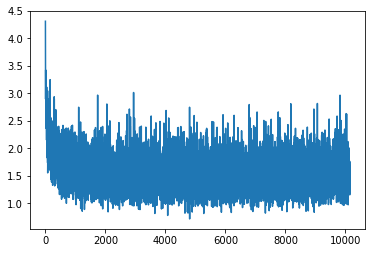

In [80]:
plt.plot(losses)